# Waveome Introduction   
In this notebook we will introduce the core functionality of waveome through a simulated data example.

## Setup

In [1]:
from waveome.model_search import GPSearch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

2024-04-23 17:47:01.701448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
metabolite = pd.read_csv(
    "/Users/alireza/DataspellProjects/waveome/examples/Breastmilk/infant_metabolite.tsv",
    header=None,sep="\t")
new_column_names = metabolite.iloc[0]
metabolite.columns = new_column_names
metabolite = metabolite.drop([0])
metabolite.reset_index(drop=True, inplace=True)
# metabolite.fillna(0, inplace=True)
metadata = pd.read_csv(
    "/Users/alireza/DataspellProjects/waveome/examples/Breastmilk/stool_metadata.csv",
    header=None,sep=",")
new_column_names = metadata.iloc[0]
metadata.columns = new_column_names
metadata = metadata.drop([0])
metadata.reset_index(drop=True, inplace=True)
df = metadata.merge(metabolite, on='X', how='right')
df['X'] = df['X'].str.extract(r'(\d+)').astype(int)
print(df.shape)# Define mapping dictionary for 'Sex'
sex_mapping = {'Female': 1, 'Male': 0}
# Define mapping dictionary for 'Maternal vs. donor'
maternal_donor_mapping = {'Maternal': 1, 'Donor': 0}
# Define mapping dictionary for 'Diet'
Diet_mapping = {'0_Exclusive_BM': 0, '1_BM_fortified_formula': 1 , '2_Exclusive_donor_BM':2 , 
                         '5_MBM_donor_milk':5 , '6_donor_milk_fortified_formula':6 , 
                         '7_MBM_DBM_fortified':7}
# Define mapping dictionary for 'Visit_time_point'
Visit_time_point_mapping = {'a': 0, 'b': 3 , 'c':7 ,'d':11}
# Replace values in 'Sex' column
df['Sex'] = df['Sex'].replace(sex_mapping)
# Replace values in 'Maternal vs. donor' column
df['Maternal_vs_donor'] = df['Maternal_vs_donor'].replace(maternal_donor_mapping)
# Replace values in 'Diet' column
df['Diet'] = df['Diet'].replace(Diet_mapping)
# Replace values in 'Visit_time_point' column
df['Visit_time_point'] = df['Visit_time_point'].replace(Visit_time_point_mapping)
# # Calculate the number of non-missing values in each column
# non_missing_counts = df.count()
# # Calculate the threshold for 25% of the total number of rows
# threshold = len(df) * 0.25
# # Filter columns where the number of non-missing values exceeds the threshold
# filtered_columns = df.columns[non_missing_counts > threshold]
# # Subset the DataFrame to include only the filtered columns
# filtered_df = df[filtered_columns]
# print(filtered_df.shape)
# print(filtered_df.columns.tolist()[0:30])
df = df.fillna(0)
new_column_names = {col: col.replace("'", "_").replace(":", "_").replace(",", "_").replace("`", "_").replace("/", "_") for col in df.columns}
df.rename(columns=new_column_names, inplace=True)
columns_to_convert = ['X', 'External_ID', 'Visit_time_point', 'Gestational_age_week', 'Gestational_age_day', 
                      'Gestational_age','Birth_weight', 'Age_at_breast_milk_sample', 'Stool_sample_date', 
                      'Age_at_stool_sample']+df.columns[13:].tolist()
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
for column_name in df.columns:
    column_type = df[column_name].dtype
    # print(f"Column '{column_name}' is {column_type}")
print(df.shape)

(72, 1169)
(72, 1169)


In [19]:
# print(df[['X', 'External_ID', 'Visit_time_point', 'Gestational_age_week', 'Gestational_age_day', 
#                       'Gestational_age','Birth_weight', 'Age_at_breast_milk_sample', 'Stool_sample_date', 
#                       'Age_at_stool_sample']])

In [4]:
selected_columns = []
for col in df.columns.tolist()[13:]:
    #### Filter the DataFrame to include only rows where the column is nonzero
    nonzero_rows = df[(df[col] != 0) & (df[col].notna())]
    # print(nonzero_rows)
    #### Count the unique 'index' groups with at least 3 nonzero values
    index_counts = nonzero_rows.groupby('X')[col].count()
    # print(index_counts)
    #### Check if there are at least 10 unique 'index' groups with at least 2 nonzero values
    if (index_counts >= 2).sum() >= 5:
        selected_columns.append(col)
# df[selected_columns]= df[selected_columns].fillna(value={"NA": 0})
df = df.fillna(0)
print(len(selected_columns))
print(df.shape)

1020
(72, 1169)


In [14]:
gps = GPSearch(
       X=df[['X', 'Gestational_age', 'Birth_weight', 'Sex', 'Maternal_vs_donor', 
             'Age_at_stool_sample', 'Diet']].astype(float),
       Y=df[selected_columns].astype(float),
       unit_col='X',
       categorical_vars=['Sex', 'Maternal_vs_donor', 'Diet'],
       outcome_likelihood= 'poisson'
)

In [15]:
gps.run_search(
    random_seed=9102
)
# Save the gps object to a file
with open('/Users/alireza/DataspellProjects/waveome/examples/Breastmilk/gps_zeromissing_poi_ALL.pkl', 'wb') as f:
    pickle.dump(gps, f)

Kernel search:   3%|▋                       | 30/1020 [14:29<6:11:17, 22.50s/it]/Users/rahlab/anaconda3/envs/waveome_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Kernel search:  24%|████▉                | 241/1020 [2:26:07<7:07:26, 32.92s/it]

IndexError with index 2 in kernel_parts ['categorical[3]', 'categorical[6]']


Kernel search: 100%|█████████████████████| 1020/1020 [10:36:19<00:00, 37.43s/it]


In [4]:
# Load the gps object from the file
with open('/Users/alireza/DataspellProjects/waveome/examples/Breastmilk/gps_zeromissing_poi_ALL.pkl', 'rb') as f:
    loaded_gps = pickle.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


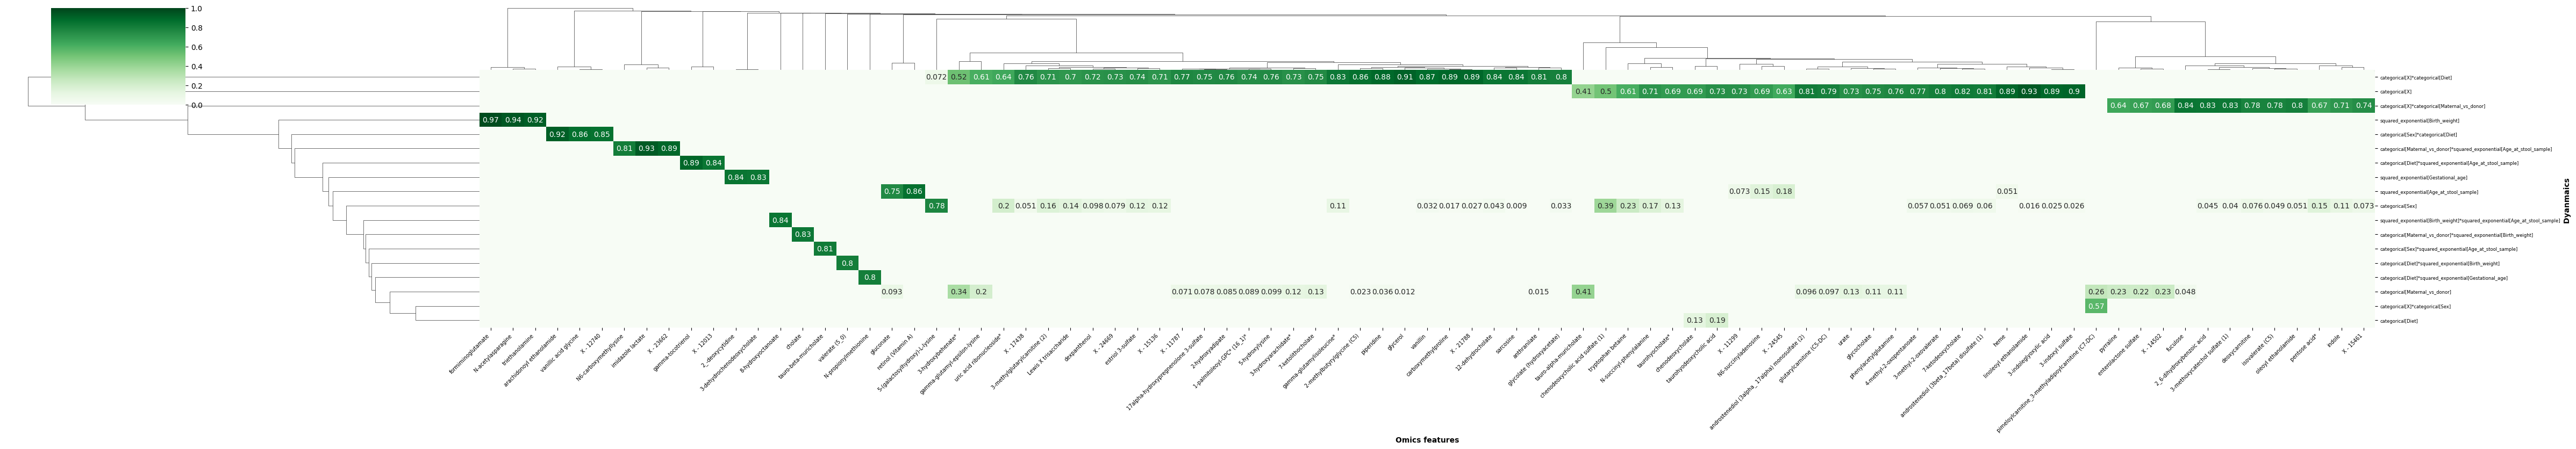

In [9]:
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
annot_kws={"size": 1}
#plt.rcParams['figure.figsize'] = 10, 3
#plt.figure(figsize=(7.2, 3))
# Assuming `gps` is your ClusterGrid
fig = loaded_gps.plot_heatmap(var_cutoff=0.8, figsize = (50, 10))
#plt = pylab.figure(figsize=(3, 2.5))
#plt.figure(figsize=(7.2, 3))
# Access the heatmap axes directly
ax_heatmap = fig.ax_heatmap
# Set xlabel on the heatmap axes
ax_heatmap.set_xlabel('Omics features', fontweight='bold', fontsize=10)
ax_heatmap.set_ylabel('Dyanmaics ', fontweight='bold', fontsize=10)


ax_heatmap.legend(framealpha = 0.2,prop={'size':1}) 

ax_heatmap.get_xaxis().set_tick_params(which='both', labelsize=6)# top='off', bottom='on', direction='out')
ax_heatmap.get_yaxis().set_tick_params(which='both', labelsize=6)

plt.savefig('/Users/alireza/Desktop/Research/Waveome Codes/Projects/Breastmilk/ISNP/Figures/Heatmap_var_cutoff_08.svg', dpi=600, bbox_inches = "tight") 
plt.savefig('/Users/alireza/Desktop/Research/Waveome Codes/Projects/Breastmilk/ISNP/Figures/Heatmap_var_cutoff_08.pdf', dpi=600, bbox_inches = "tight") 
plt.show() 

ShapeMismatchError: 
Tensor shape mismatch.
  Function: Poisson._conditional_mean
    Declared: /Users/alireza/anaconda3/envs/waveome/lib/python3.8/site-packages/gpflow/likelihoods/scalar_discrete.py:62
    Argument: X
      Expected: [broadcast batch..., input_dim]
      Actual:   [1000, 7]
    Argument: F
      Expected: [broadcast batch..., latent_dim]
      Actual:   [1000]
    Argument: return
      Expected: [batch..., observation_dim]
      Actual:   [1000]


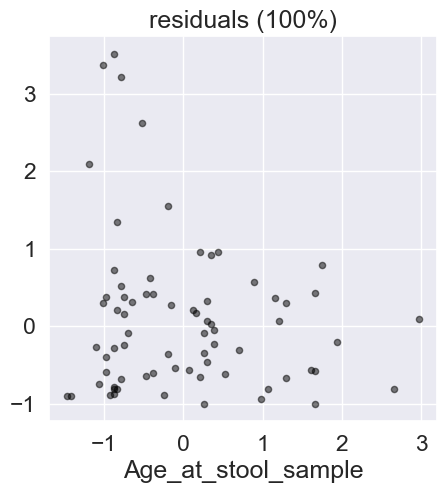

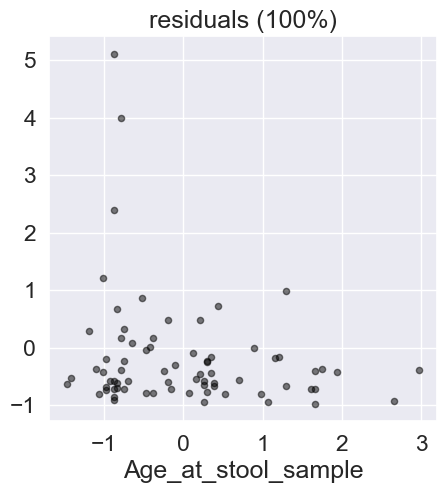

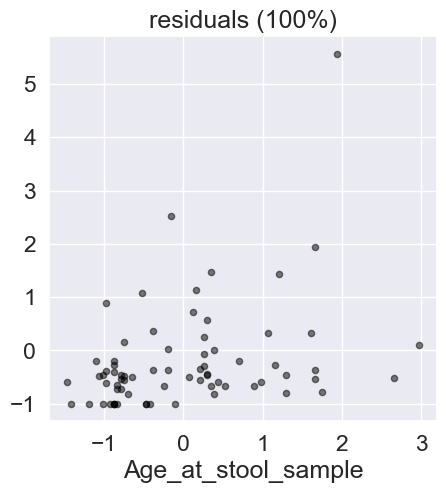

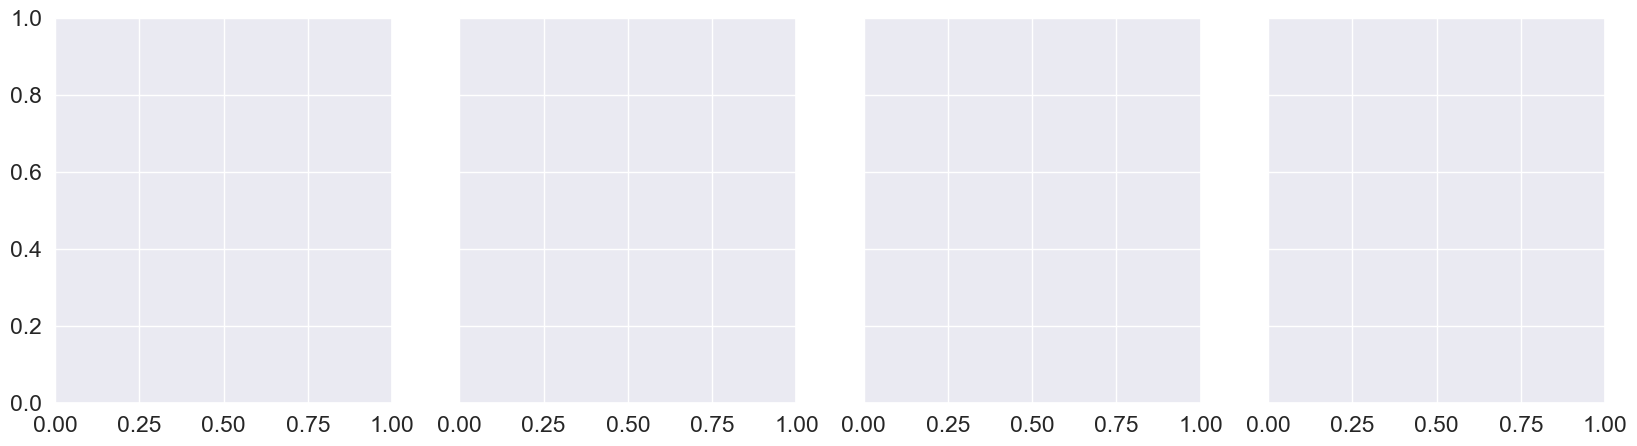

In [18]:
import numpy as np
# Set the font size
sns.set(font_scale=1.5)  # You can adjust this scaling factor
# Create the plots
for column in selected_columns:
    # Replace "/" with "_"=
    column_safe = column.replace("/", "_")
    fig, axes = loaded_gps.plot_parts(
        out_label=column, 
        x_axis_label='Age_at_stool_sample',
        unit_label=0
    )
    # Set the facecolor of the figure to be transparent
    # fig.patch.set_facecolor('none')
    # fig.patch.set_alpha(0)
    # Iterate over both dimensions of the subplots array and customize the plots
    # plt.savefig(f'/Users/alireza/Desktop/Research/Waveome Codes/Projects/Breastmilk/ISNP/Figures/{column_safe}.pdf', dpi=300, bbox_inches="tight")

In [19]:
print(selected_columns[0:100])

['(14 or 15)-methylpalmitate (a17:0 or i17:0)', '(16 or 17)-methylstearate (a19:0 or i19:0)', '(2 or 3)-decenoate (10:1n7 or n8)', '(N(1) + N(8))-acetylspermidine', '(R)-3-hydroxybutyrylcarnitine', '(S)-3-hydroxybutyrylcarnitine', '(S)-a-amino-omega-caprolactam', '1,2,3-benzenetriol sulfate (2)', '1,2-dilinoleoyl-GPC (18:2/18:2)', '1,2-dipalmitoyl-GPC (16:0/16:0)', '1,2-dipalmitoyl-GPE (16:0/16:0)*', '1,3,7-trimethylurate', '1,3-diaminopropane', '1,3-dimethylurate', '1,3-propanediol', '1,7-dimethylurate', '1-(1-enyl-oleoyl)-GPE (P-18:1)*', '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*', '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*', '1-(1-enyl-palmitoyl)-GPE (P-16:0)*', '1-(1-enyl-stearoyl)-GPE (P-18:0)*', '1-arachidonylglycerol (20:4)', '1-carboxyethylhistidine', '1-carboxyethylisoleucine', '1-carboxyethylleucine', '1-carboxyethylphenylalanine', '1-carboxyethylvaline', '1-dihomo-linolenylglycerol (20:3)', '1-dihomo-linoleoylglycerol (20:2)', '1-docosahexaenoylglyc

ShapeMismatchError: 
Tensor shape mismatch.
  Function: Poisson._conditional_mean
    Declared: /Users/alireza/anaconda3/envs/waveome/lib/python3.8/site-packages/gpflow/likelihoods/scalar_discrete.py:62
    Argument: X
      Expected: [broadcast batch..., input_dim]
      Actual:   [1000, 7]
    Argument: F
      Expected: [broadcast batch..., latent_dim]
      Actual:   [1000]
    Argument: return
      Expected: [batch..., observation_dim]
      Actual:   [1000]


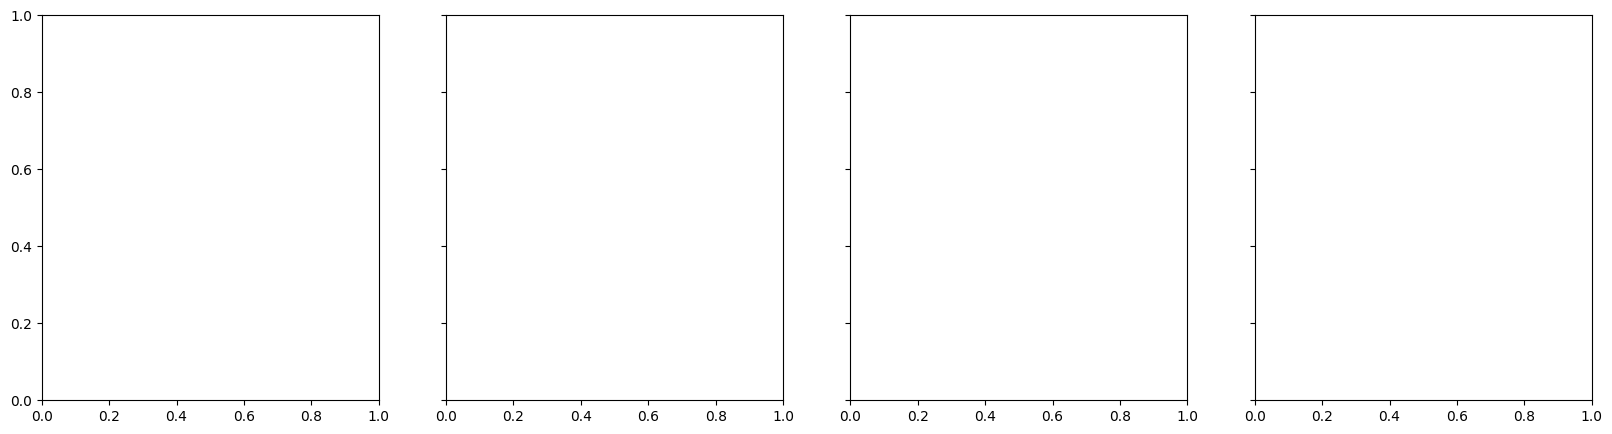

In [10]:
fig, axes = loaded_gps.plot_parts(
        out_label='N6-carboxymethyllysine', 
        x_axis_label='Age_at_stool_sample',
    )
    # Set the facecolor of the figure to be transparent
    # fig.patch.set_facecolor('none')
    # fig.patch.set_alpha(0)
    # Iterate over both dimensions of the subplots array and customize the plots
    # plt.savefig(f'/Users/alireza/Desktop/Research/Waveome Codes/Projects/waveomeSleeve/waveome_LipidPlots/{column_safe}.svg', dpi=6400, bbox_inches="tight")
    # plt.savefig(f'/Users/alireza/Desktop/Research/Waveome Codes/Projects/waveomeSleeve/waveome_LipidPlots/{column_safe}.pdf', dpi=6400, bbox_inches="tight")

(<Figure size 2000x500 with 2 Axes>,
 array([[<Axes: title={'center': 'categorical[index]*\nsquared_exponential[time](97.5%)'}, xlabel='time'>,
         <Axes: title={'center': 'residuals (2.5%)'}, xlabel='time'>,
         <Axes: >, <Axes: >]], dtype=object))

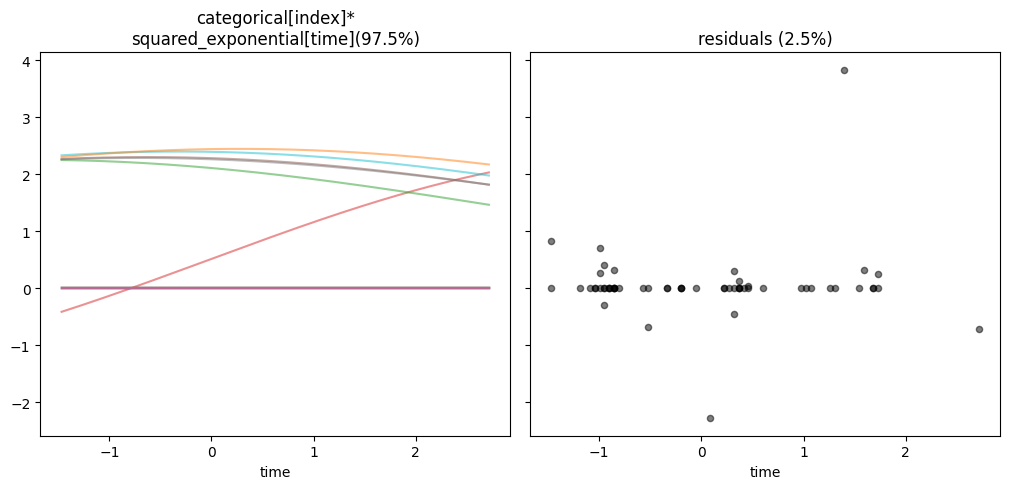

In [9]:
gps.plot_parts(
    out_label='Escherichia_coli', 
    x_axis_label='time',
    unit_label=0
)

(<Figure size 2000x500 with 3 Axes>,
 array([[<Axes: title={'center': 'categorical[index](43.4%)'}, xlabel='time'>,
         <Axes: title={'center': 'squared_exponential[time](29.8%)'}, xlabel='time'>,
         <Axes: title={'center': 'residuals (26.7%)'}, xlabel='time'>,
         <Axes: >]], dtype=object))

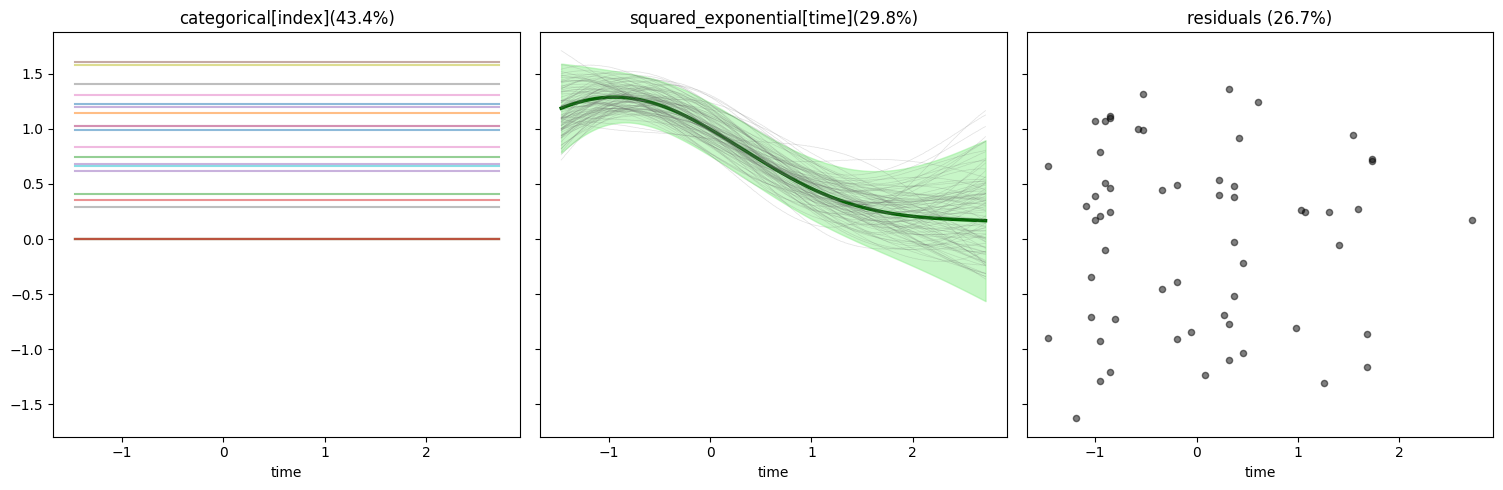

In [21]:
gps.plot_parts(
    out_label='Staphylococcus_epidermidis', 
    x_axis_label='time',
    unit_label=0
)

Finally, we might be interested in seeing the relationships found between outcomes during the search process. We can view this with a heatmap like the one shown below. Each row is an additive model component, each column is an outcome, and the filled in values are the explained variation of the outcome by that model component.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


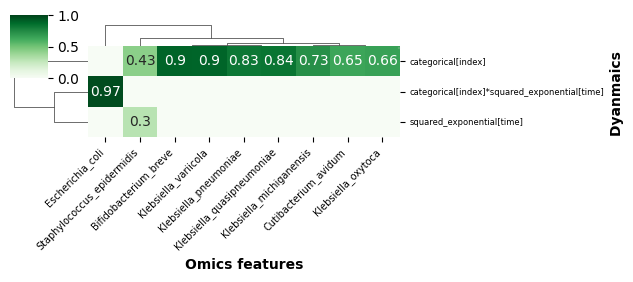

In [24]:
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
annot_kws={"size": 1}
#plt.rcParams['figure.figsize'] = 10, 3
#plt.figure(figsize=(7.2, 3))
# Assuming `gps` is your ClusterGrid
fig = gps.plot_heatmap(var_cutoff=0.1, figsize = (7.5, 3.5))
#plt = pylab.figure(figsize=(3, 2.5))
#plt.figure(figsize=(7.2, 3))
# Access the heatmap axes directly
ax_heatmap = fig.ax_heatmap
# Set xlabel on the heatmap axes
ax_heatmap.set_xlabel('Omics features', fontweight='bold', fontsize=10)
ax_heatmap.set_ylabel('Dyanmaics ', fontweight='bold', fontsize=10)


ax_heatmap.legend(framealpha = 0.2,prop={'size':1}) 

ax_heatmap.get_xaxis().set_tick_params(which='both', labelsize=7)# top='off', bottom='on', direction='out')
ax_heatmap.get_yaxis().set_tick_params(which='both', labelsize=6)

plt.savefig('/Users/alireza/Downloads/rest_metrics1.pdf', dpi=350, bbox_inches = "tight") 
# plt.savefig('/content/drive/My Drive/omicsEye/deepOmics/Figures/rest_metrics.png', dpi=350, bbox_inches = "tight") 
# plt.show()

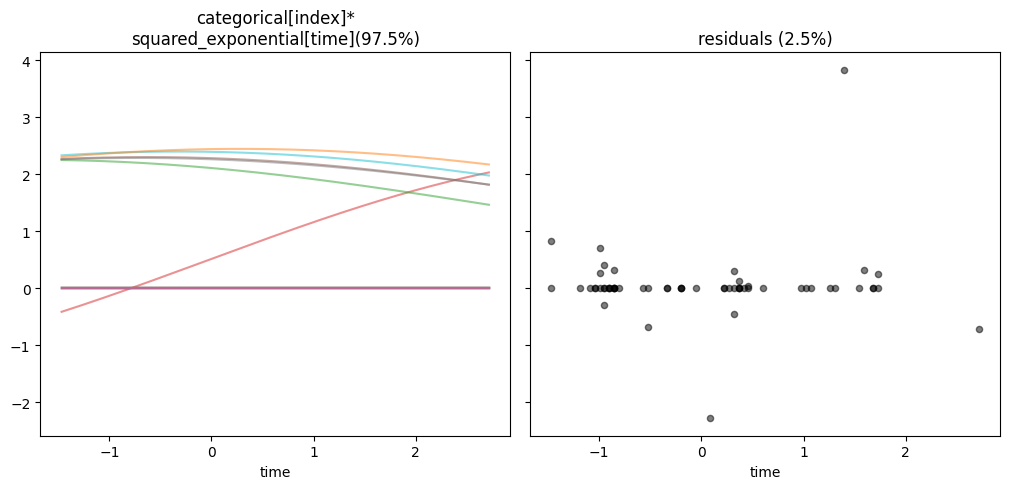

In [29]:
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
annot_kws={"size": 1}
#plt.rcParams['figure.figsize'] = 10, 3
#plt.figure(figsize=(7.2, 3))
# Assuming `gps` is your ClusterGrid
parts = gps.plot_parts(
    out_label='Escherichia_coli', 
    x_axis_label='time',
    unit_label=0
)
#plt = pylab.figure(figsize=(3, 2.5))
#plt.figure(figsize=(7.2, 3))
# Access the heatmap axes directly
# ax_heatmap = parts.ax_heatmap
# # Set xlabel on the heatmap axes
ax_heatmap.set_xlabel('Omics features', fontweight='bold', fontsize=10)
ax_heatmap.set_ylabel('Dyanmaics ', fontweight='bold', fontsize=10)


# ax_heatmap.legend(framealpha = 0.2,prop={'size':1}) 

# ax_heatmap.get_xaxis().set_tick_params(which='both', labelsize=7)# top='off', bottom='on', direction='out')
# ax_heatmap.get_yaxis().set_tick_params(which='both', labelsize=6)

plt.savefig('/Users/alireza/Downloads/parts_Escherichia_coli.pdf', dpi=350, bbox_inches = "tight") 
# plt.savefig('/content/drive/My Drive/omicsEye/deepOmics/Figures/rest_metrics.png', dpi=350, bbox_inches = "tight") 
# plt.show()

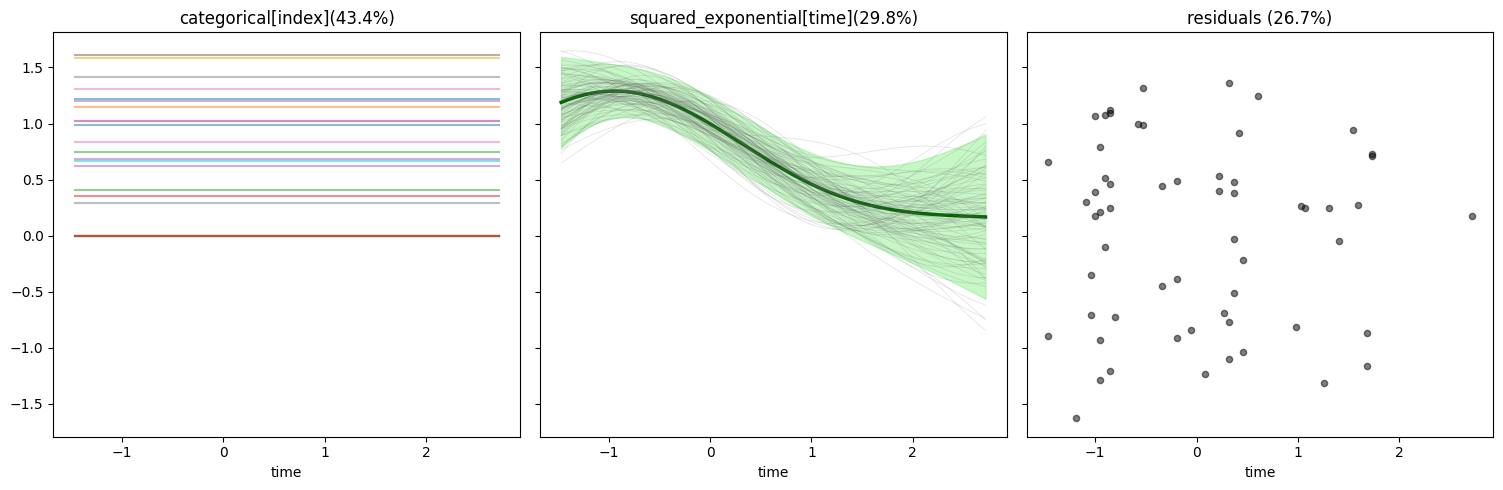

In [30]:
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
annot_kws={"size": 1}
#plt.rcParams['figure.figsize'] = 10, 3
#plt.figure(figsize=(7.2, 3))
# Assuming `gps` is your ClusterGrid
parts = gps.plot_parts(
    out_label='Staphylococcus_epidermidis', 
    x_axis_label='time',
    unit_label=0
)
#plt = pylab.figure(figsize=(3, 2.5))
#plt.figure(figsize=(7.2, 3))
# Access the heatmap axes directly
# ax_heatmap = parts.ax_heatmap
# # Set xlabel on the heatmap axes
# ax_heatmap.set_xlabel('Omics features', fontweight='bold', fontsize=10)
# ax_heatmap.set_ylabel('Dyanmaics ', fontweight='bold', fontsize=10)


# ax_heatmap.legend(framealpha = 0.2,prop={'size':1}) 

# ax_heatmap.get_xaxis().set_tick_params(which='both', labelsize=7)# top='off', bottom='on', direction='out')
# ax_heatmap.get_yaxis().set_tick_params(which='both', labelsize=6)

plt.savefig('/Users/alireza/Downloads/parts_Staphylococcus_epidermidis.pdf', dpi=350, bbox_inches = "tight") 
# plt.savefig('/content/drive/My Drive/omicsEye/deepOmics/Figures/rest_metrics.png', dpi=350, bbox_inches = "tight") 
# plt.show()

From this quick tutorial we have seen how to use waveome to model longitudinal data.

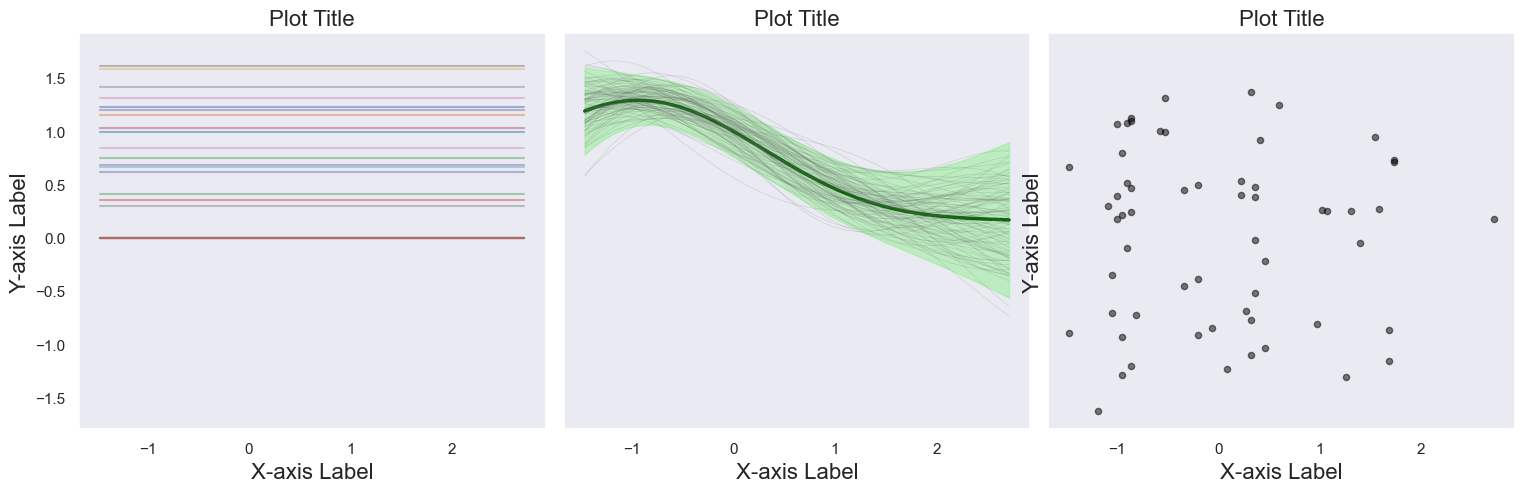

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the font size
sns.set(font_scale=1.0)  # You can adjust this scaling factor

# Create the plots
fig, axes = gps.plot_parts(
    out_label='Staphylococcus_epidermidis',
    x_axis_label='time',
    unit_label=0
)

# Set the facecolor of the figure to be transparent
fig.patch.set_facecolor('none')
fig.patch.set_alpha(0)

# Iterate over both dimensions of the subplots array and customize the plots
for row in axes:
    for ax in row:
        ax.set_xlabel('X-axis Label', fontsize=16)
        ax.set_ylabel('Y-axis Label', fontsize=16)
        ax.set_title('Plot Title', fontsize=16)

        # Remove grid lines
        ax.grid(False)

# Save the plot
plt.savefig('/Users/alireza/Downloads/parts_Staphylococcus_epidermidis1111.pdf', dpi=350, bbox_inches="tight")






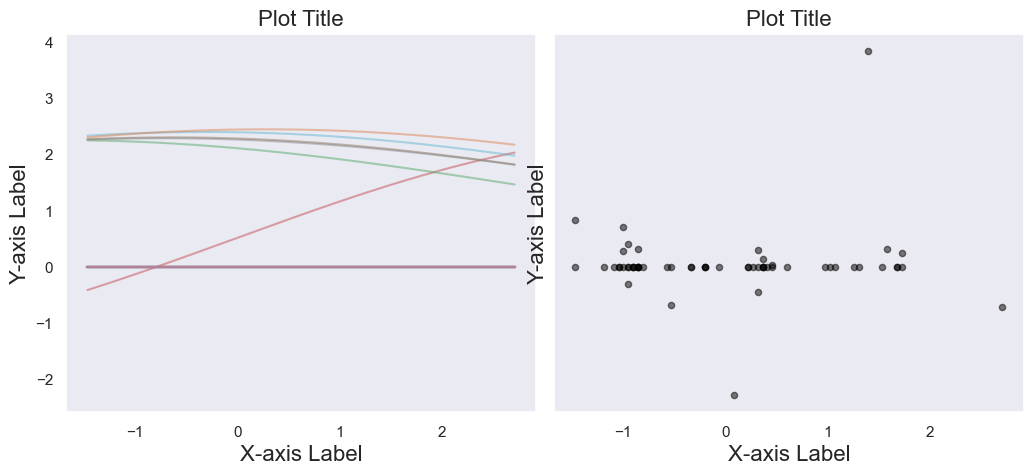

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the font size
sns.set(font_scale=1.0)  # You can adjust this scaling factor

# Create the plots
fig, axes = gps.plot_parts(
    out_label='Escherichia_coli',
    x_axis_label='time',
    unit_label=0
)

# Set the facecolor of the figure to be transparent
fig.patch.set_facecolor('none')
fig.patch.set_alpha(0)

# Iterate over both dimensions of the subplots array and customize the plots
for row in axes:
    for ax in row:
        ax.set_xlabel('X-axis Label', fontsize=16)
        ax.set_ylabel('Y-axis Label', fontsize=16)
        ax.set_title('Plot Title', fontsize=16)

        # Remove grid lines
        ax.grid(False)

# Save the plot
plt.savefig('/Users/alireza/Downloads/parts_Escherichia_coli1111.pdf', dpi=350, bbox_inches="tight")




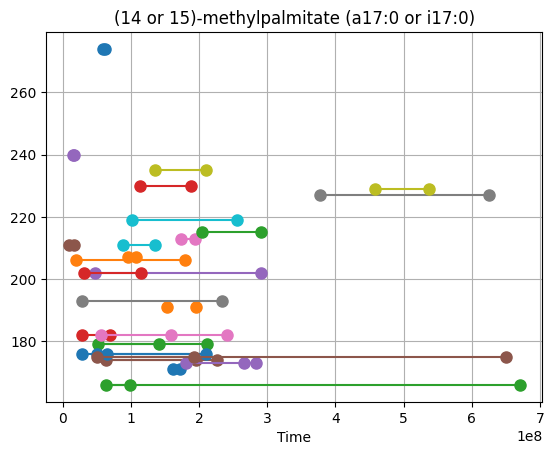

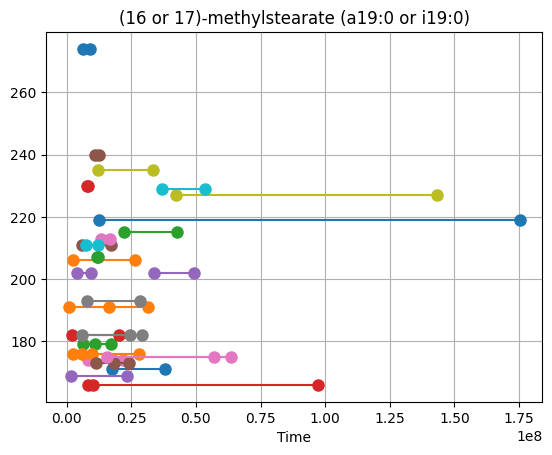

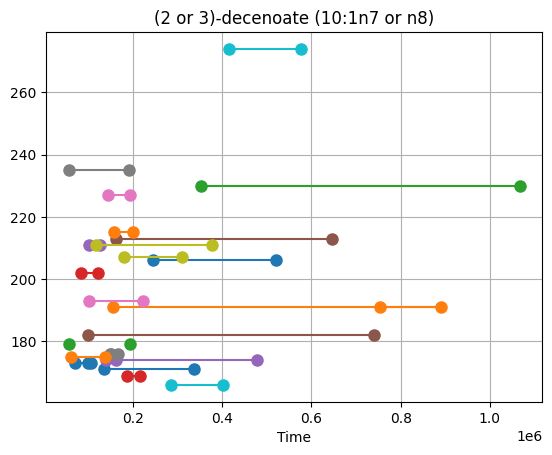

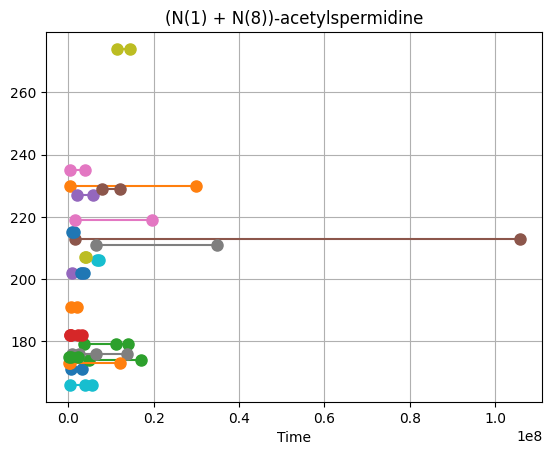

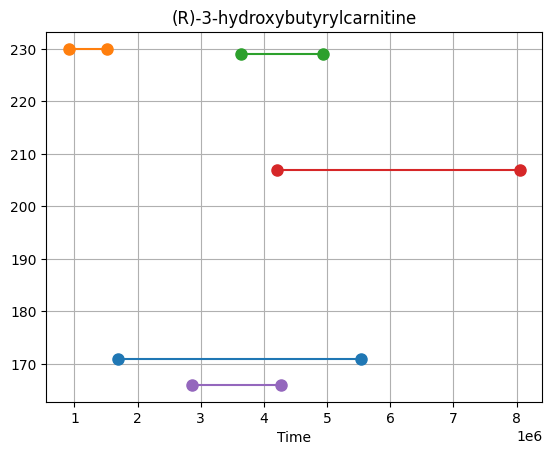

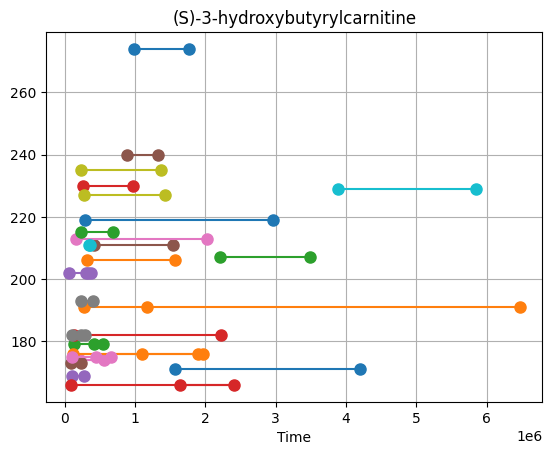

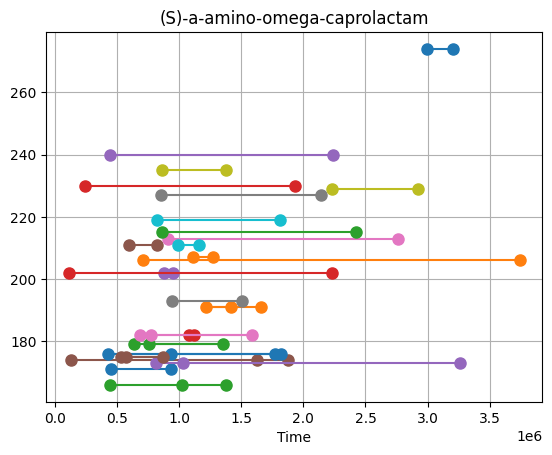

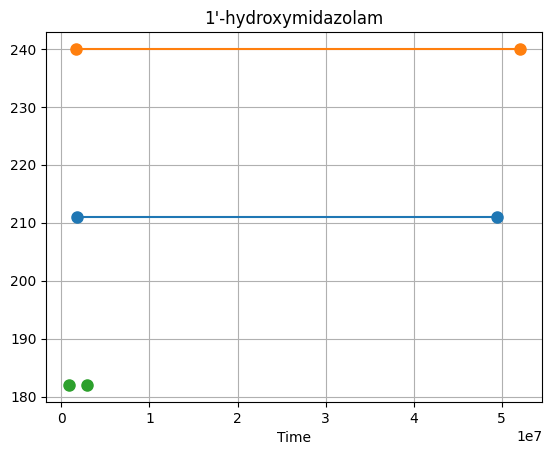

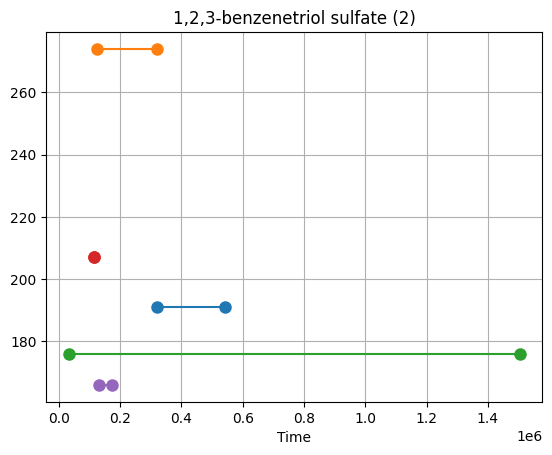

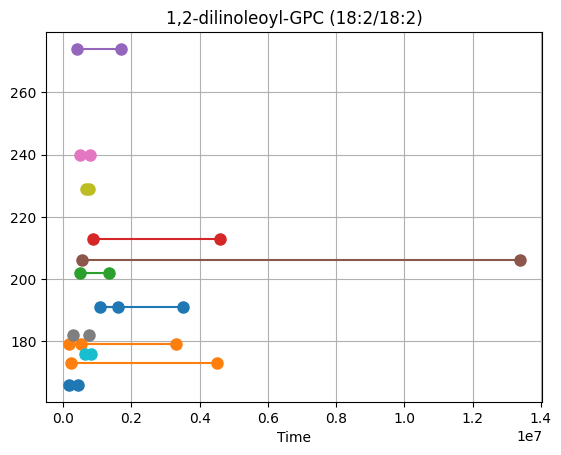

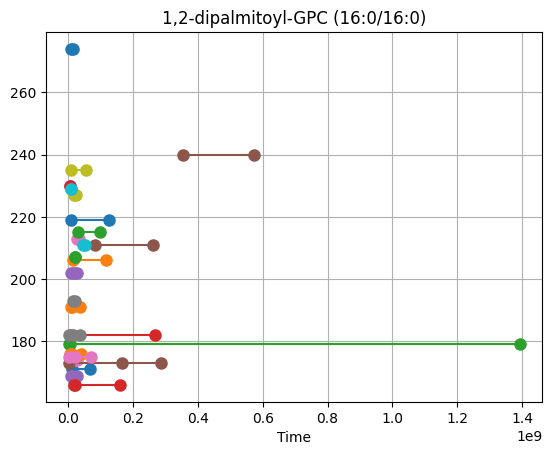

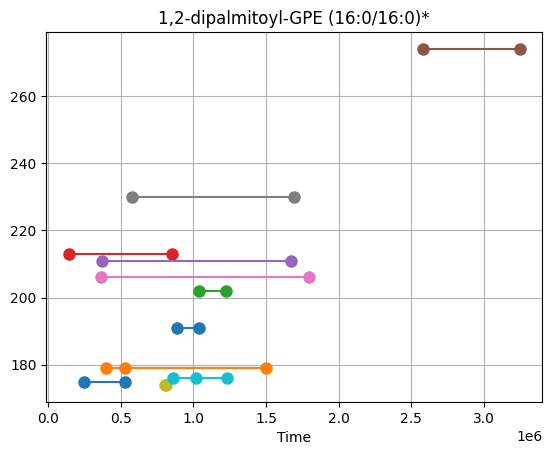

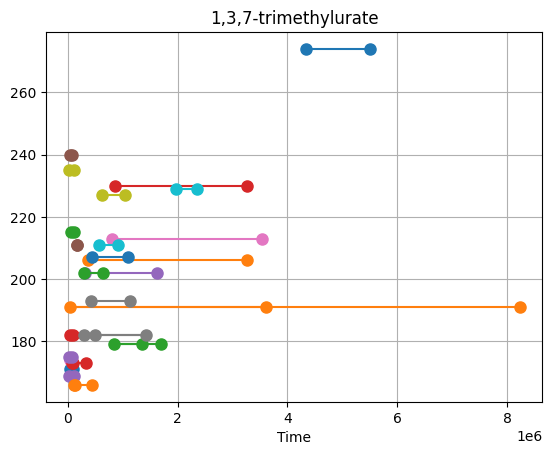

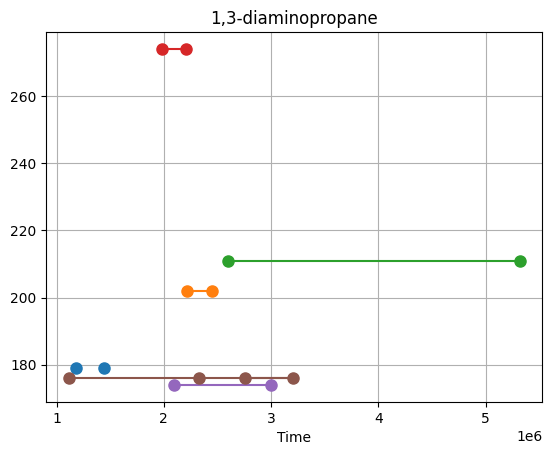

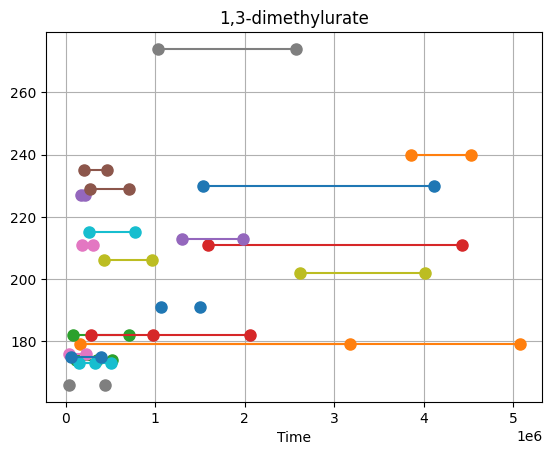

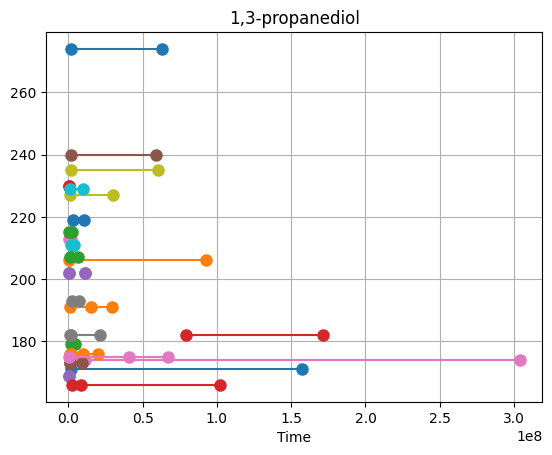

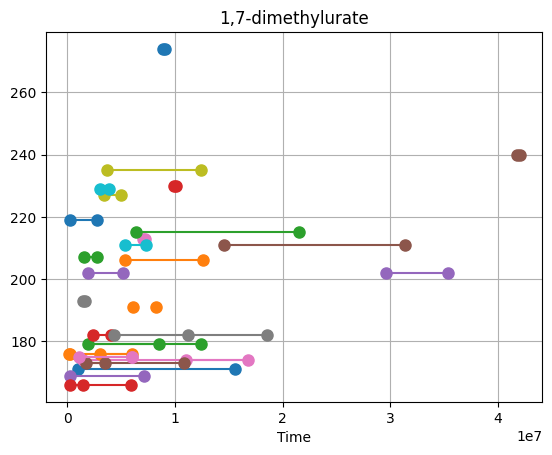

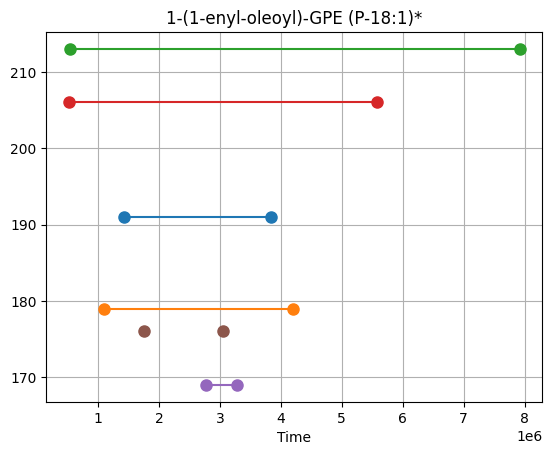

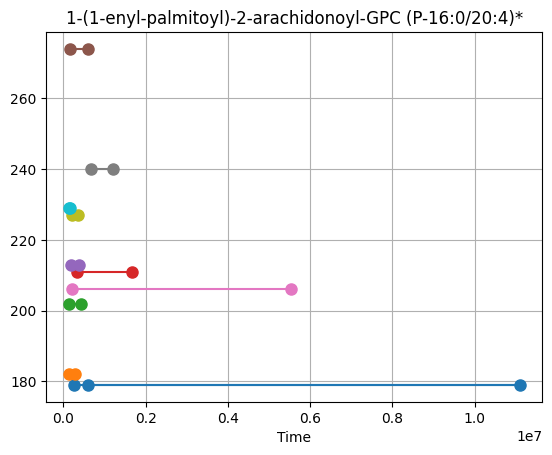

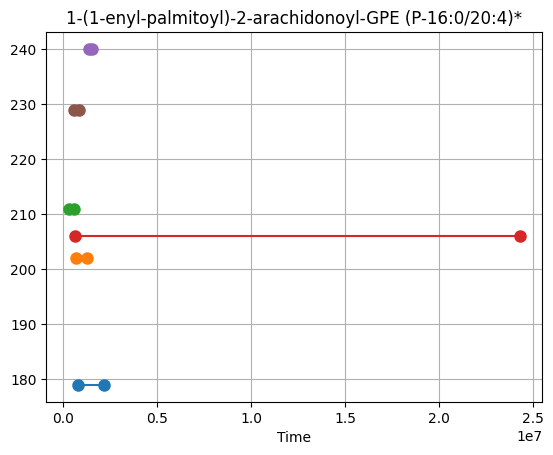

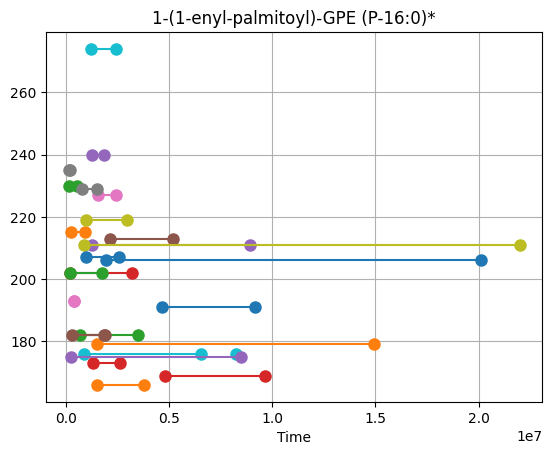

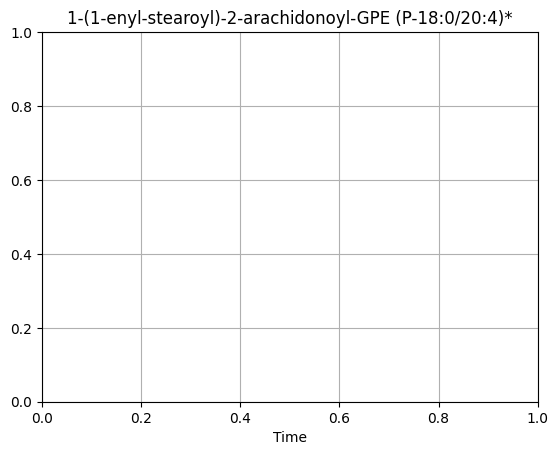

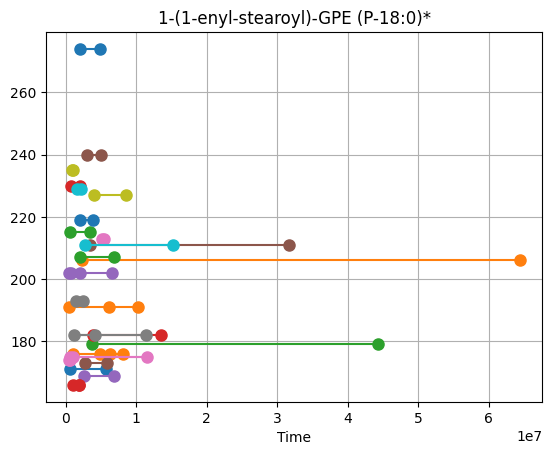

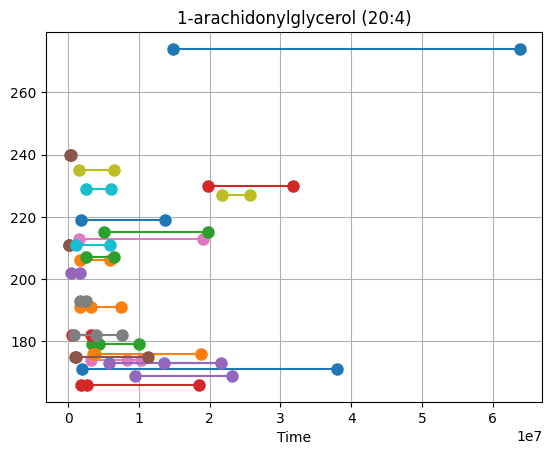

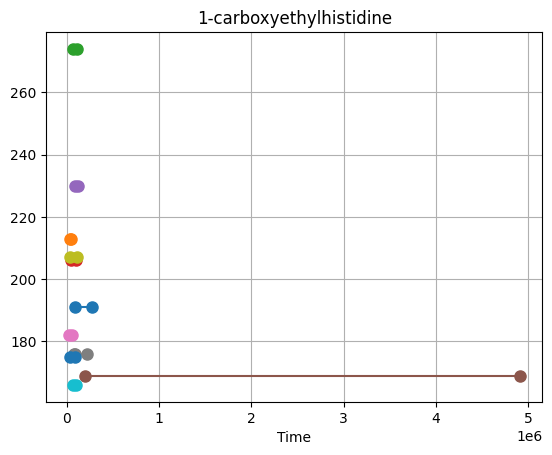

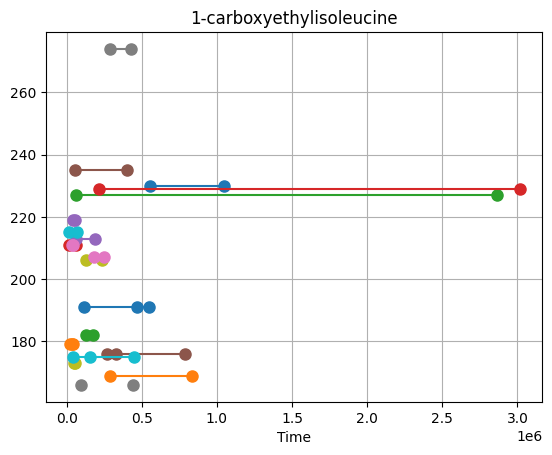

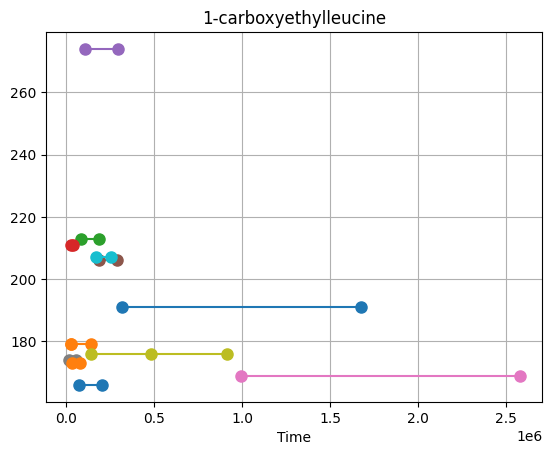

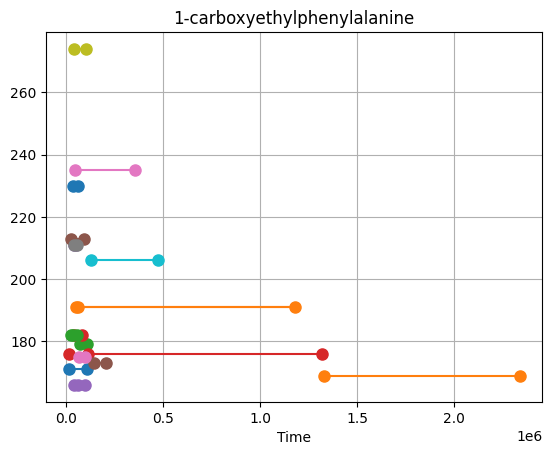

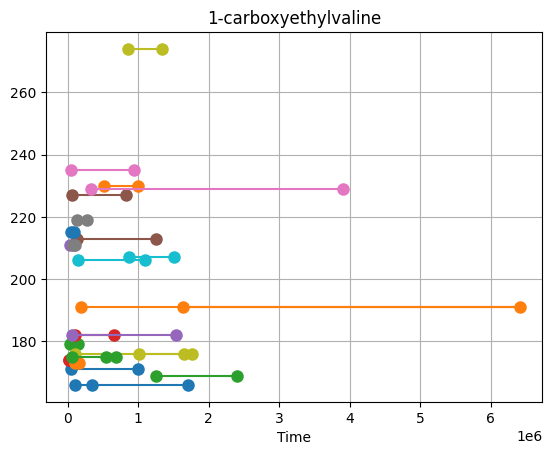

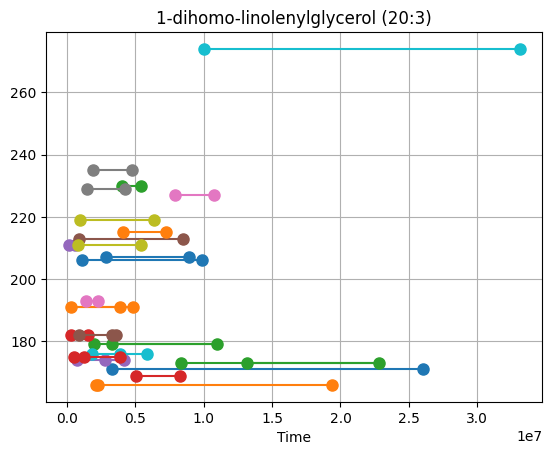

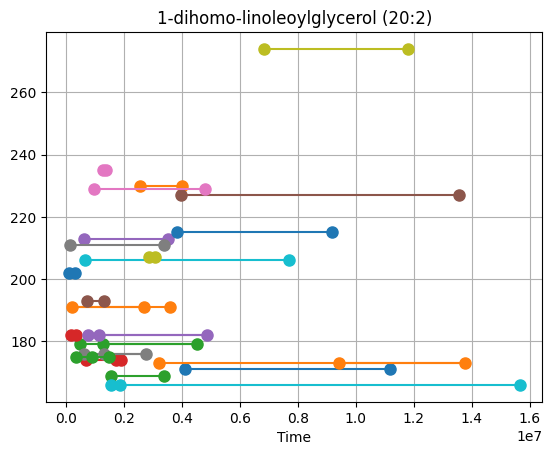

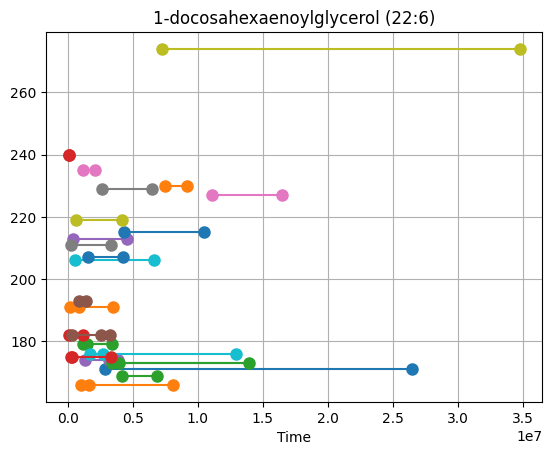

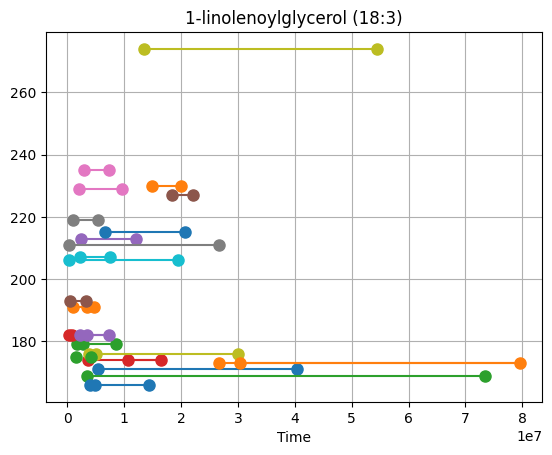

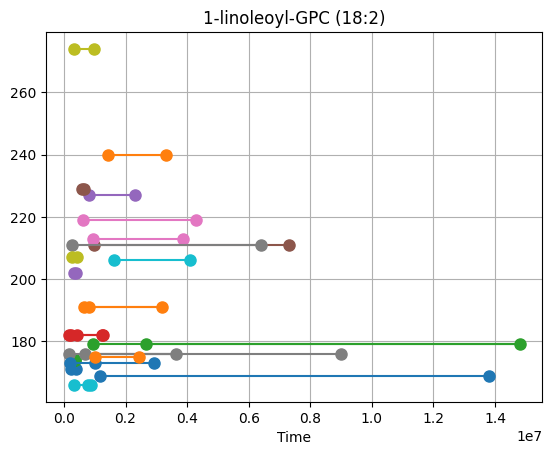

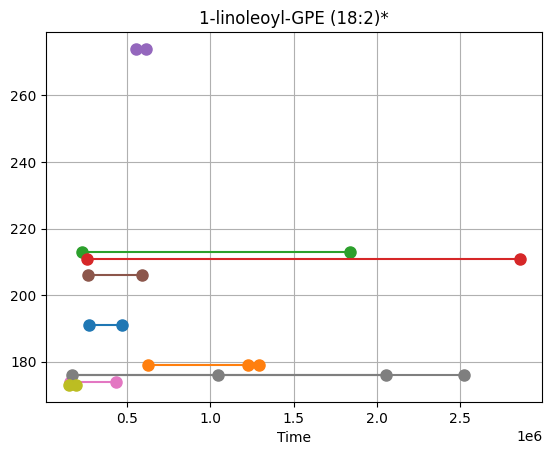

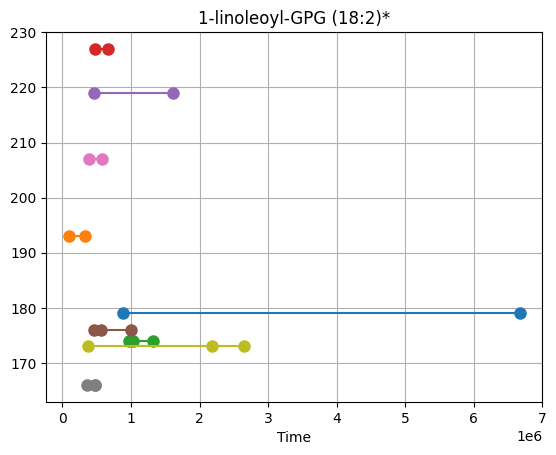

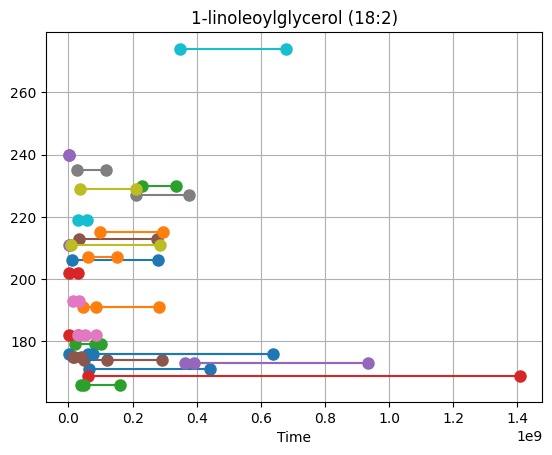

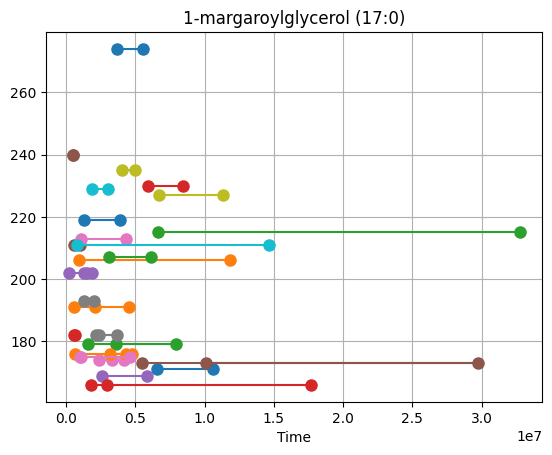

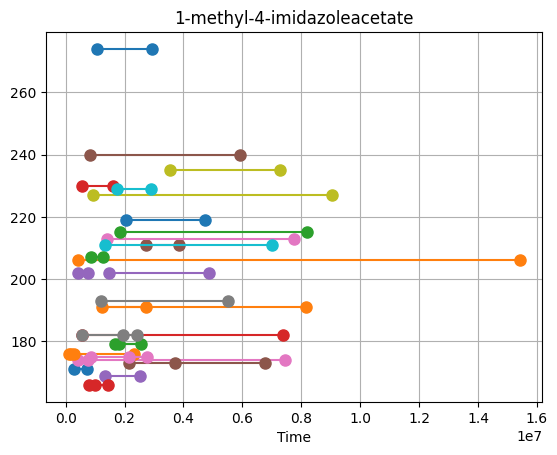

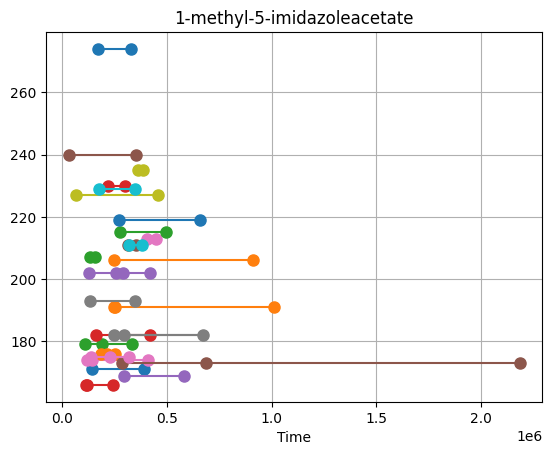

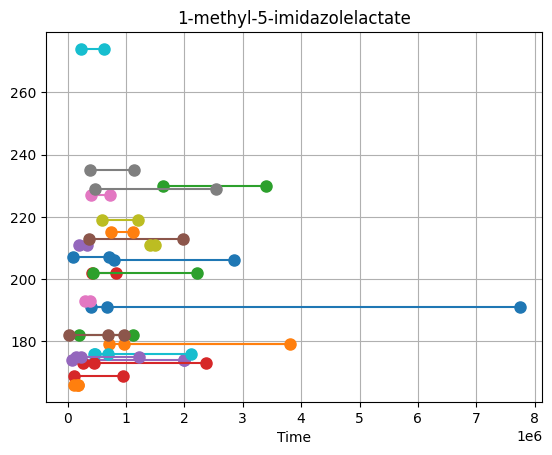

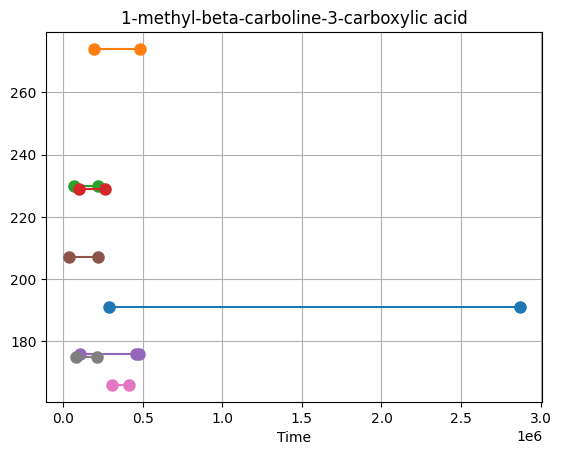

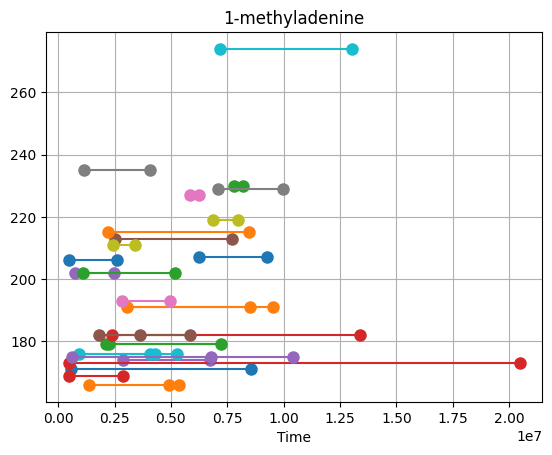

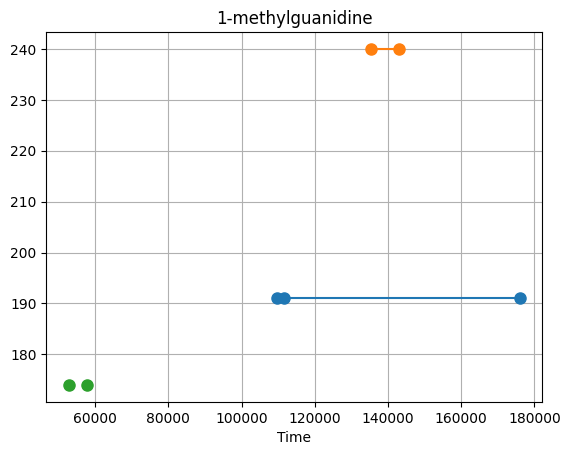

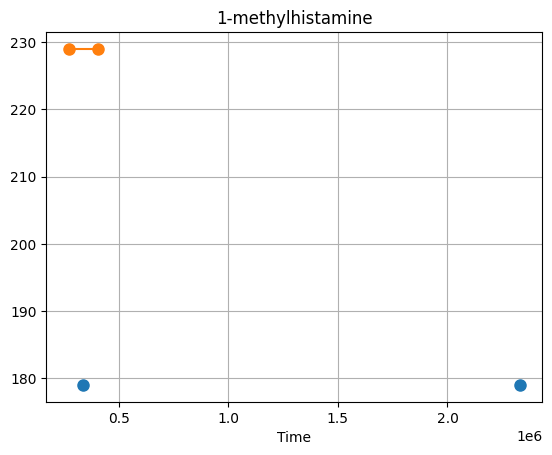

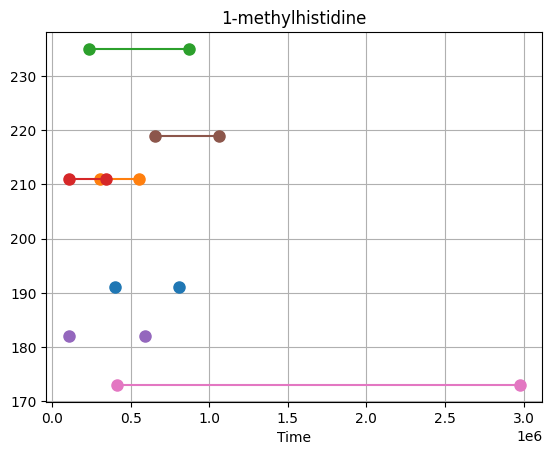

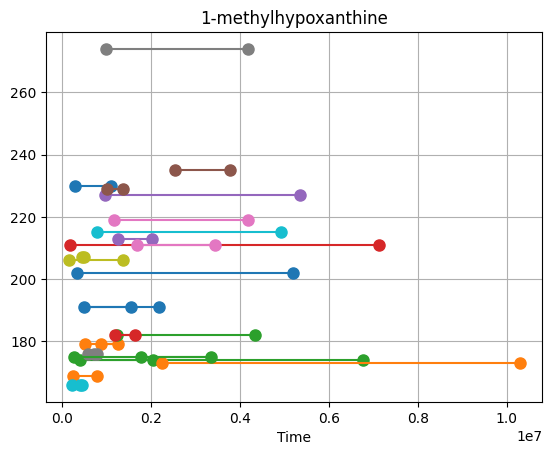

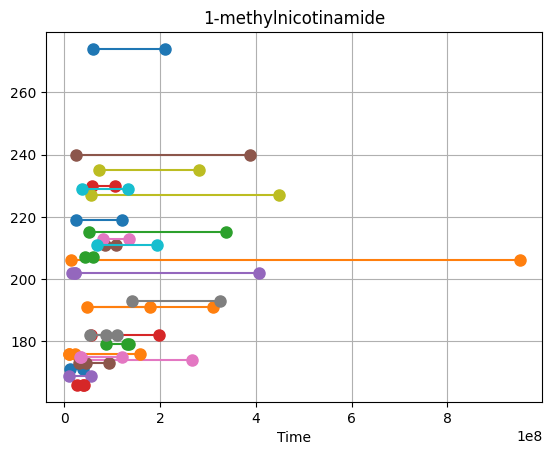

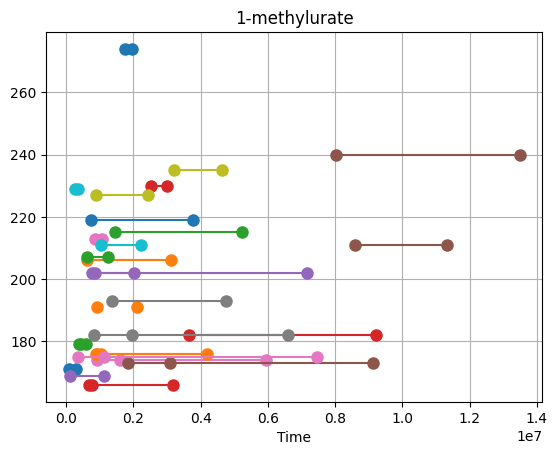

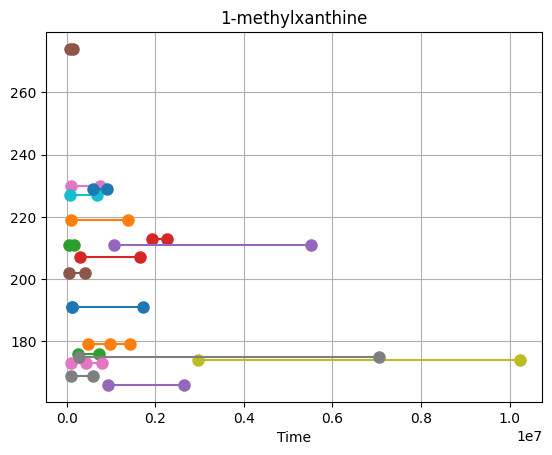

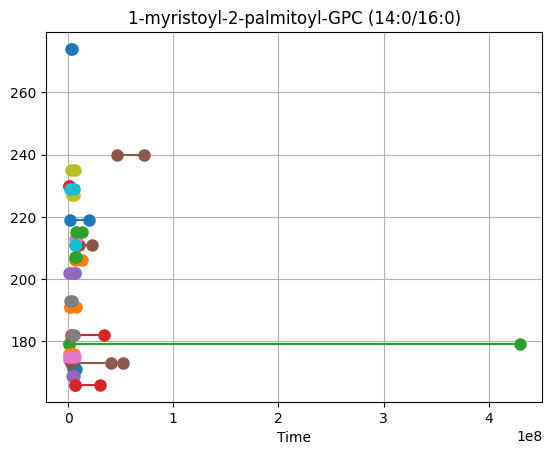

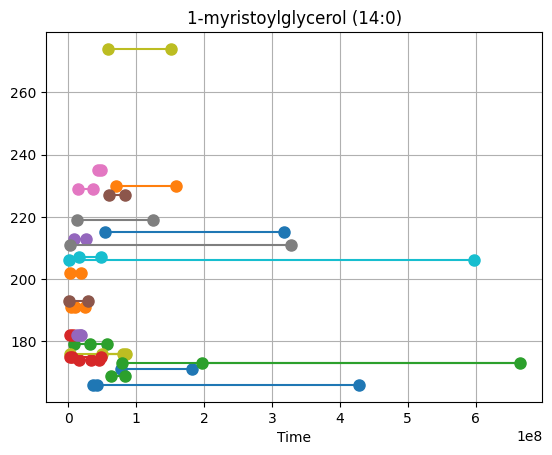

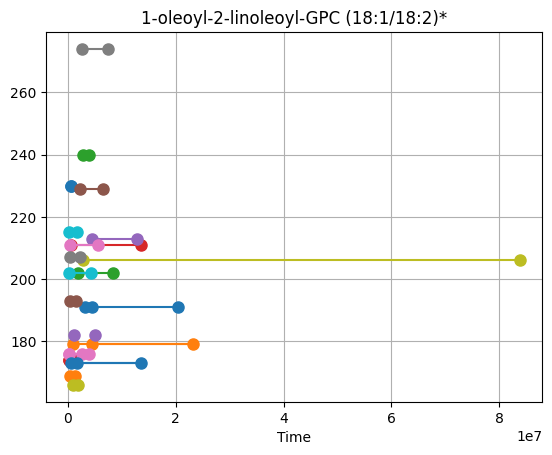

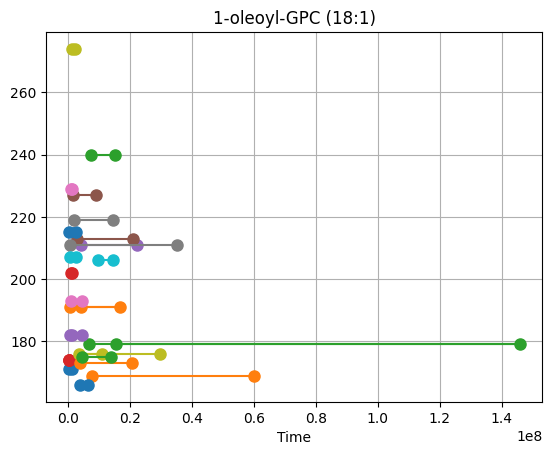

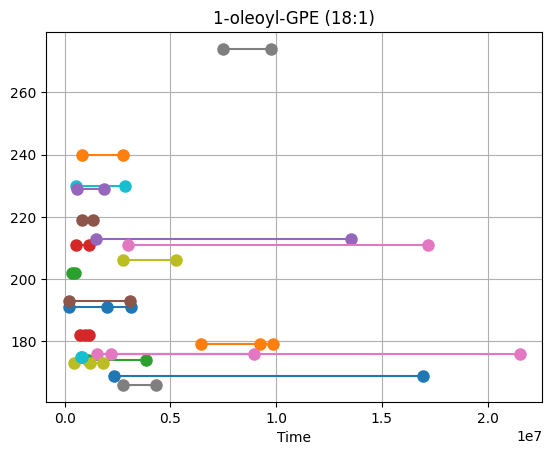

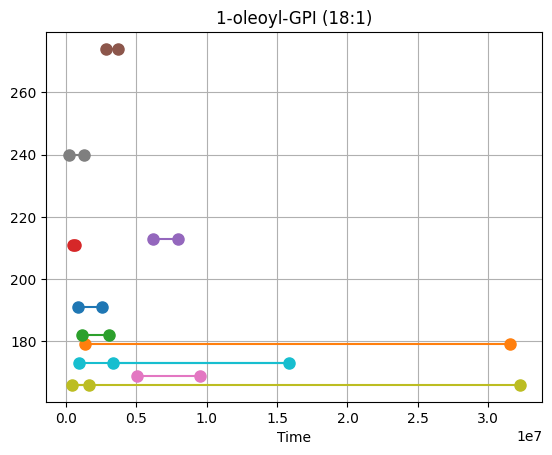

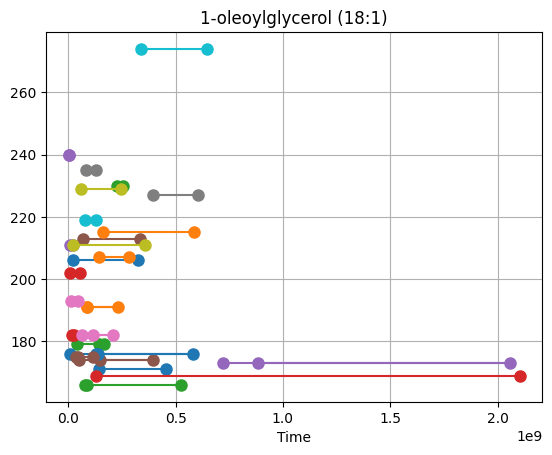

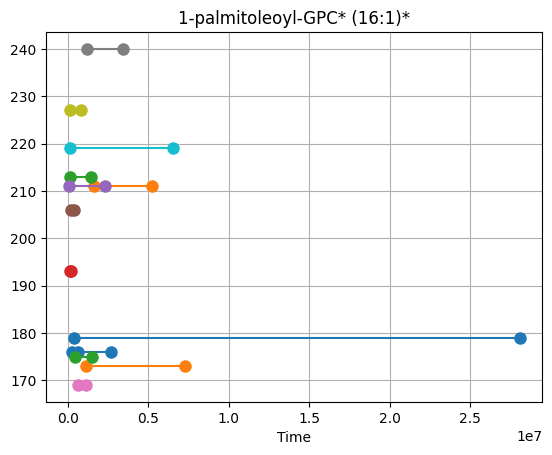

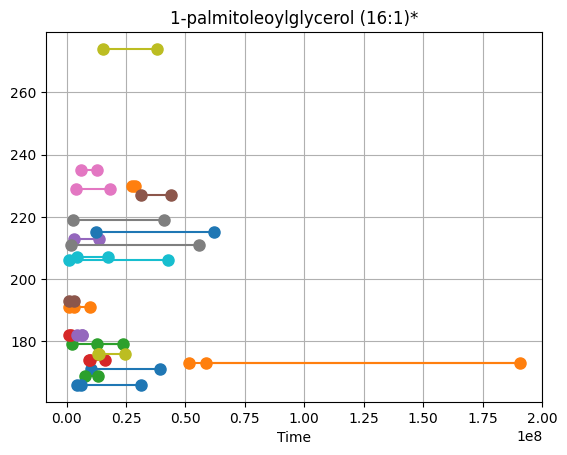

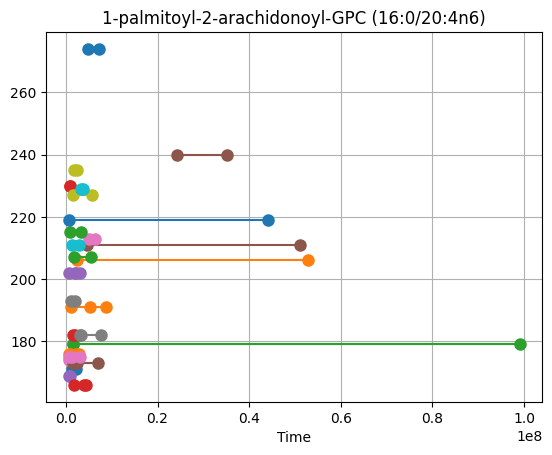

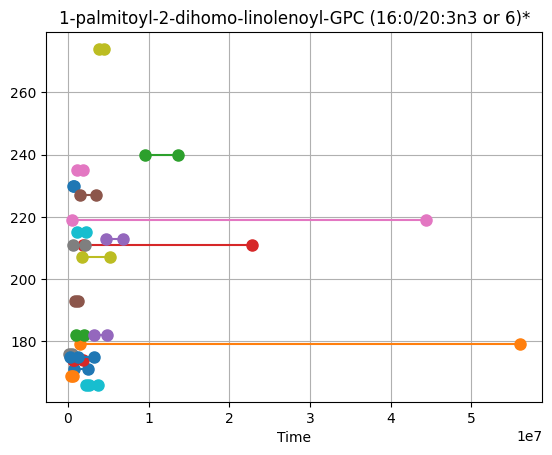

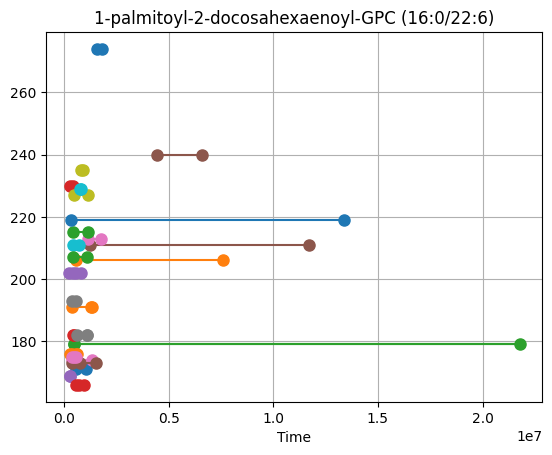

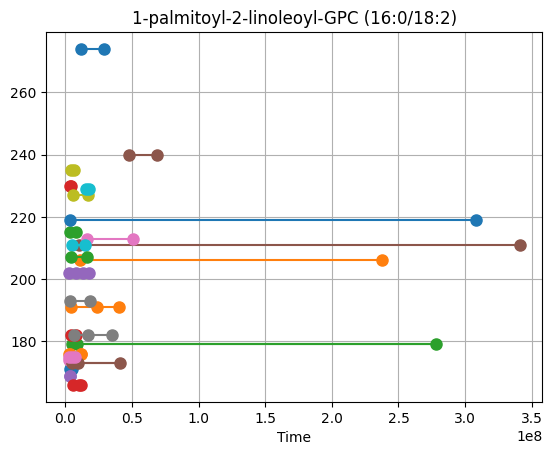

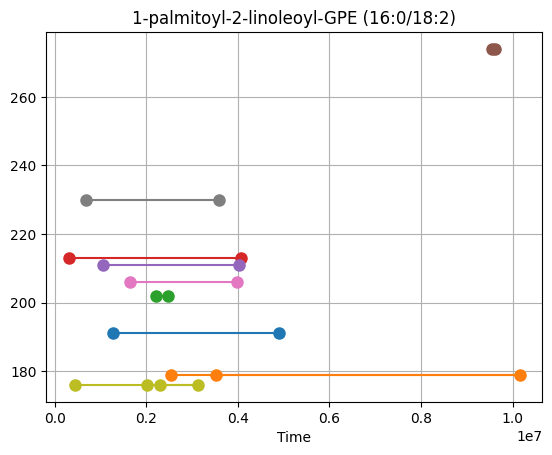

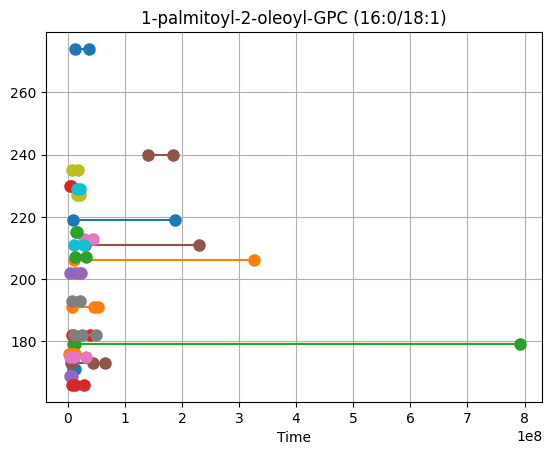

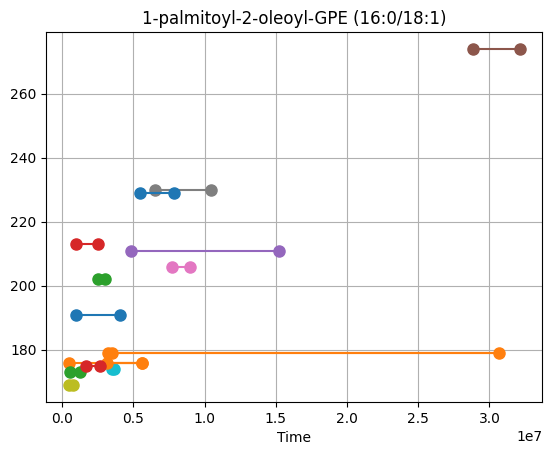

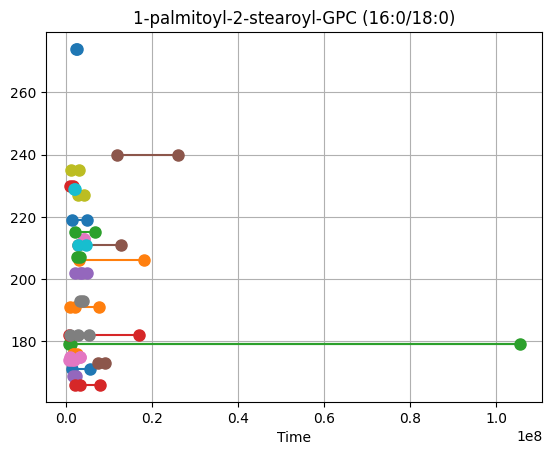

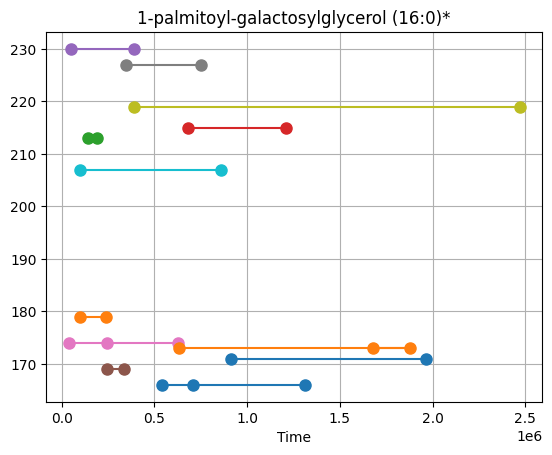

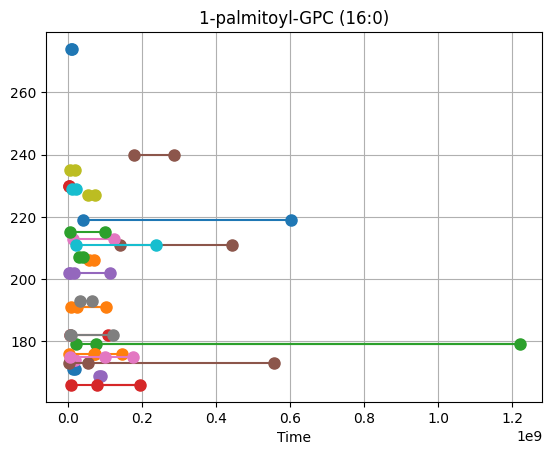

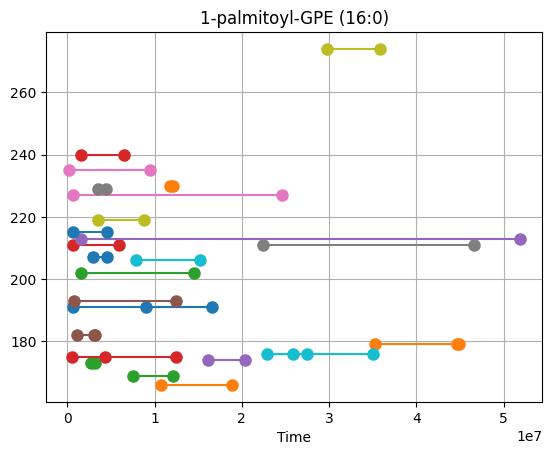

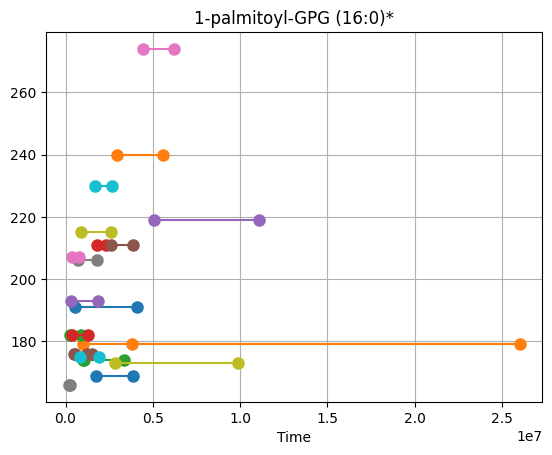

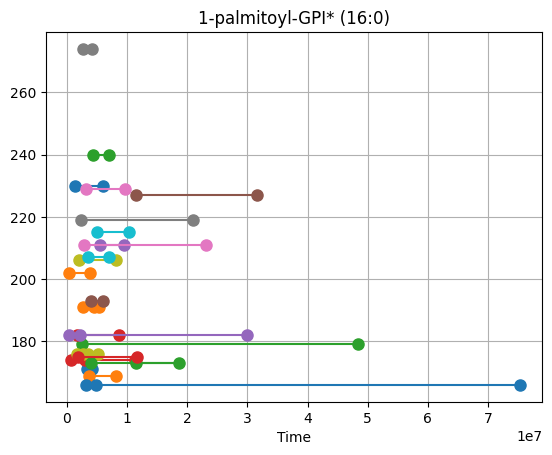

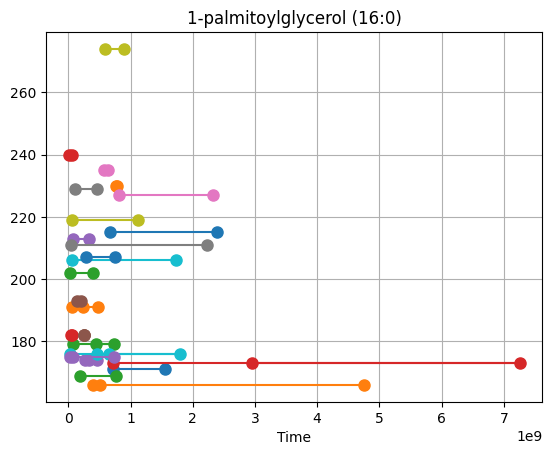

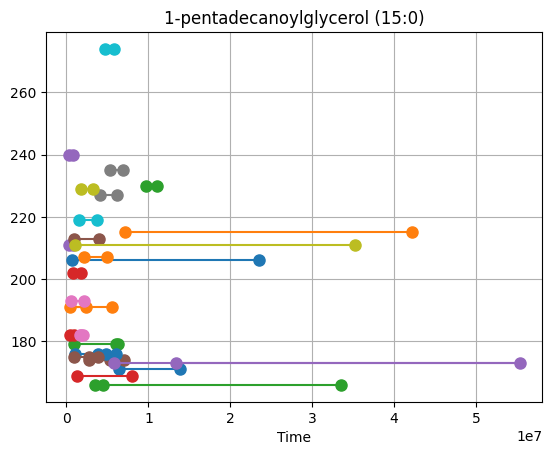

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [39]:
# Get the unique index values
unique_indexes = df['X'].unique()
# list of numeric-values columns
# Iterate over the columns
for out in df.columns.tolist()[14:]:
    # Initialize a list to store the indexes with at least two measurements
    valid_indexes = []
    # Check for each index if it has at least two measurements
    for i in unique_indexes:
        if df.loc[df['X'] == i, out].count() >= 2:
            valid_indexes.append(i)
        # Plot data for valid indexes
    for i in valid_indexes:
        plt.plot(df.loc[df['X'] == i, 'Gestational age'], df.loc[df['X'] == i, out], marker='o', markersize=8, linestyle='-')
    plt.title(out)
    plt.xlabel('Time')
    plt.grid(True)
    plt.show()